In [1]:
import warnings

warnings.simplefilter("ignore")

import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
# Utility function to report best scores
def report(results, n_top=3):
    """Utility function to report best scores
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print("Score: {0:f} (std: {1:f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Pars: {0}".format(results['params'][candidate]))
            print("")
            

def report2(results, n_top=3):
    """Utility function to report best scores
    """
    print("Rank|Score(std)|Params", list(results['params'][0].keys()))
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("{0}|".format(i), end="")
            print("{0:f}(std:{1:f})|".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]), end="")
            print("{0}".format(list(results['params'][candidate].values())))

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

----
# modify features

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [4]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

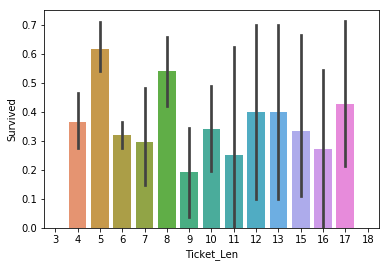

In [5]:
sns.barplot(data=train_df, x="Ticket_Len", y="Survived")

In [6]:
train_df['Ticket_Len'].value_counts(dropna=False)

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

In [7]:
test_df['Ticket_Len'].value_counts(dropna=False)

6     183
5      62
4      47
8      42
10     22
9      11
11     10
13      9
7       9
18      8
12      6
15      3
17      2
16      2
3       2
Name: Ticket_Len, dtype: int64

----

## make Cabin First character feature

In [8]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

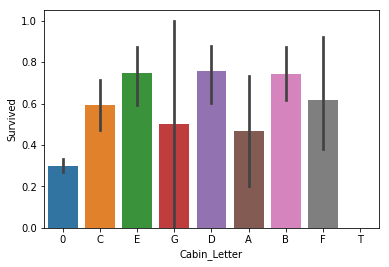

In [9]:
sns.barplot(data=train_df, x="Cabin_Letter", y="Survived")

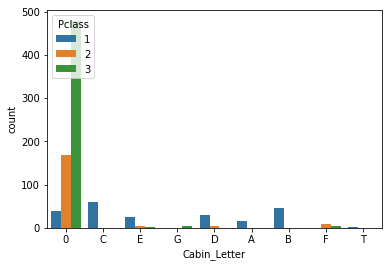

In [10]:
sns.countplot(data=train_df, x="Cabin_Letter", hue="Pclass")

### make one Cabin_Letter feature by numerical

### make dummy variable for Cabin_Letter

In [11]:
train_test_df = pd.concat((train_df, test_df))

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

train_df = train_test_df.iloc[:train_df.shape[0]]

test_df = train_test_df.iloc[train_df.shape[0]:]
test_df = test_df.drop("Survived", axis=1) # drop added Survived column from test_df

combine = [train_df, test_df]

**if you made Cabin_num features too, duplicate feature for NaN. delete one of these**

----

## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

**CabinBool is inclueded in Cabin letter and cabin number**
**no need to use**

----

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [12]:
#for i in [train_df, test_df]:
for i in combine:
    i['Cabin_num'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num'].replace('an', np.NaN, inplace = True)
    i['Cabin_num'] = i['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)


In [13]:
train_df['Cabin_num_Band'] = pd.qcut(train_df['Cabin_num'], 3)

train_df['Cabin_num_Band'].value_counts(dropna=False) 

#NaN                 691
#(65.667, 148.0]      67
#(1.999, 28.667]      67
#(28.667, 65.667]     66


NaN                 691
(65.667, 148.0]      67
(1.999, 28.667]      67
(28.667, 65.667]     66
Name: Cabin_num_Band, dtype: int64

In [14]:
train_df['Cabin_num_Band'] = train_df['Cabin_num_Band'].cat.add_categories("nan_category")
train_df['Cabin_num_Band'] = train_df['Cabin_num_Band'].fillna("nan_category")


In [15]:
train_df.groupby(["Cabin_num_Band"])["Survived"].value_counts(dropna=False)

Cabin_num_Band    Survived
(1.999, 28.667]   1.0          48
                  0.0          19
(28.667, 65.667]  1.0          43
                  0.0          23
(65.667, 148.0]   1.0          43
                  0.0          24
nan_category      0.0         483
                  1.0         208
Name: Survived, dtype: int64

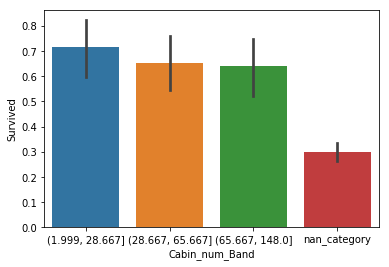

In [16]:
sns.barplot(data=train_df, x="Cabin_num_Band", y="Survived")

In [17]:
# 3 cabin num band
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Cabin_num'] <= 28.667, 'Cabin_num'] = 0
    dataset.loc[(dataset['Cabin_num'] > 28.667) & (dataset['Cabin_num'] <= 65.667), 'Cabin_num'] = 1
    dataset.loc[ dataset['Cabin_num'] > 65.667, 'Cabin_num'] = 2
combine = [train_df, test_df]


In [18]:
train_df = train_df.drop(['Cabin_num_Band'], axis=1)
combine = [train_df, test_df]

In [19]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix='Cabin_num', dummy_na=True)), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix='Cabin_num', dummy_na=True)), axis = 1)
combine = [train_df, test_df]

In [20]:
del train_df['Cabin_num']
del test_df['Cabin_num']
combine = [train_df, test_df]

In [21]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Len',
       'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C',
       'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G',
       'Cabin_Letter_T', 'Cabin_num_0.0', 'Cabin_num_1.0', 'Cabin_num_2.0',
       'Cabin_num_nan'],
      dtype='object')

----

## del Ticket, Cabin columns

In [22]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

----

## add title

In [23]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

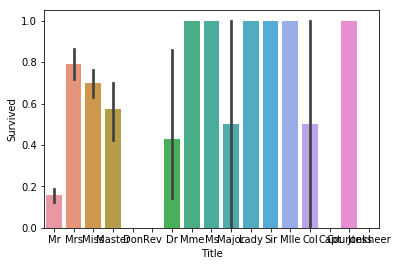

In [24]:
sns.barplot(data=train_df, x="Title", y="Survived")

In [25]:
train_df.Title.value_counts(dropna=False)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Don           1
Lady          1
Sir           1
Jonkheer      1
Mme           1
Capt          1
Countess      1
Ms            1
Name: Title, dtype: int64

----

## make name length feature

In [26]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

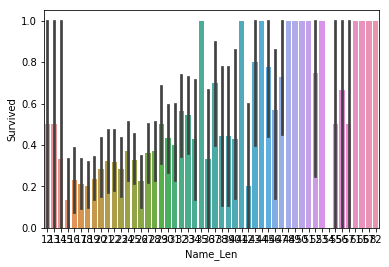

In [27]:
sns.barplot(data=train_df, x="Name_Len", y="Survived")

----

## map value to Sex 

In [28]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

----

## make Age_Null_Flag if the Age is nulll

In [29]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

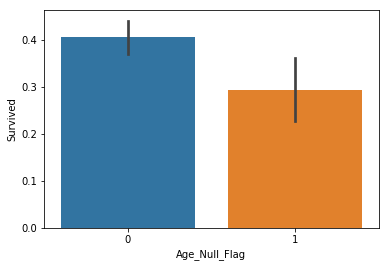

In [30]:
sns.barplot(data=train_df, x="Age_Null_Flag", y="Survived")

In [31]:
train_df["Age_Null_Flag"].value_counts(dropna=False)

0    714
1    177
Name: Age_Null_Flag, dtype: int64

In [32]:
test_df["Age_Null_Flag"].value_counts(dropna=False)

0    332
1     86
Name: Age_Null_Flag, dtype: int64

----

## fill na of Age

options

- by Sex and Pclass
- by Title and Pclass

In [33]:
pd.cut(train_df['Age'], 5).value_counts(dropna=False)

(16.336, 32.252]    346
(32.252, 48.168]    188
NaN                 177
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

### by Sex and Pclass

### fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I modified.

In [34]:
train_test_df = pd.concat((train_df, test_df))

groupedAge_train_test = train_test_df.groupby(['Title', 'Pclass'])['Age']

# fill by title and pclass. 
# but one grouped row doesn't have Age num. 
# So need to group by only Title and fill of the mean value.
train_test_df.Age = groupedAge_train_test.transform(lambda x:x.fillna(x.mean()))

# fill by just title because no value row if group by title and pclass
groupedByTitleOnly_Age_train_test = train_test_df.groupby(['Title'])['Age']
train_test_df.Age = groupedByTitleOnly_Age_train_test.transform(lambda x:x.fillna(x.mean()))

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop(["Survived"], axis=1)

combine = [train_df, test_df]

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

**2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.**
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

----

### add age band

- 5 age band by pd.cut
- 10 age band by pd.cut: this is better score.

if i use pd.qcut, band become too short for young adult around 25.

**first, check age band and Survived feature in train_df**

In [35]:
pd.cut(train_df['Age'], 5).value_counts(dropna=False)

(16.336, 32.252]    472
(32.252, 48.168]    235
(0.34, 16.336]      104
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

In [36]:
pd.cut(train_df['Age'], 10).value_counts(dropna=False)

(24.294, 32.252]    260
(16.336, 24.294]    212
(32.252, 40.21]     136
(40.21, 48.168]      99
(0.34, 8.378]        58
(8.378, 16.336]      46
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: Age, dtype: int64

In [37]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
combine = [train_df, test_df]

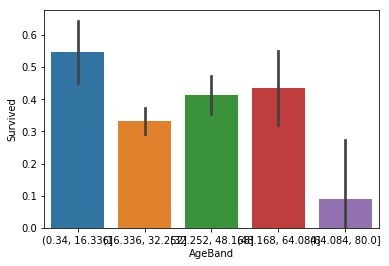

In [38]:
sns.barplot(x="AgeBand", data=train_df, y="Survived")

In [39]:
train_df.groupby(["AgeBand"]).Survived.value_counts()

AgeBand           Survived
(0.34, 16.336]    1.0          57
                  0.0          47
(16.336, 32.252]  0.0         315
                  1.0         157
(32.252, 48.168]  0.0         138
                  1.0          97
(48.168, 64.084]  0.0          39
                  1.0          30
(64.084, 80.0]    0.0          10
                  1.0           1
Name: Survived, dtype: int64

### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [40]:
# 5 age band
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

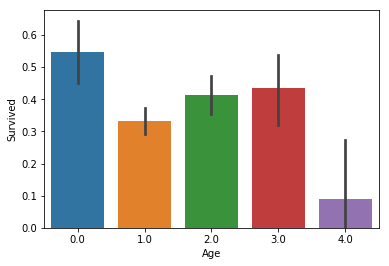

In [41]:
sns.barplot(data=train_df, x="Age", y="Survived")

----

## convert Title to numerical or one hot encoding

several options

1. one hot encoding, no deleting rare title
2. change rare title to "Rare" and map value
  - 2.1. Replacing rare titles with more common ones
3. modify known title to usual, change rare title to "Rare" and one hot encoding

### 1. one hot encoding, no deleteing rare title

### 2. change rare titles to "Rare" and map value

**del rare title and map value**

#### 2.1. Replacing rare titles with more common ones**

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/

### 3. modify known title to usual, change rare title to "Rare" and one hot encoding

In [42]:
mapping = {'Mlle': 'Miss', 
            'Major': 'Mr', 
            'Col': 'Mr', 
            'Sir': 'Mr',
            'Don': 'Mr', 
            'Mme': 'Miss',
            'Jonkheer': 'Mr',
            'Lady': 'Mrs', 
            'Capt': 'Mr', 
            'Countess': 'Mrs',
            'Ms': 'Miss',
            'Dona': 'Mrs'}

train_df.replace({'Title': mapping}, inplace=True)
test_df.replace({'Title': mapping}, inplace=True)

combine = [train_df, test_df]

train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 32) (418, 31)


In [43]:
train_df.columns

Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'Embarked', 'Fare',
       'Name', 'Name_Len', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rev'],
      dtype='object')

----

## Create new feature "FamilySize", "IsAlone", "Age*Class"

In [44]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

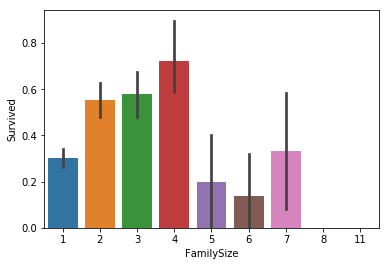

In [45]:
sns.barplot(data=train_df, x="FamilySize", y="Survived")

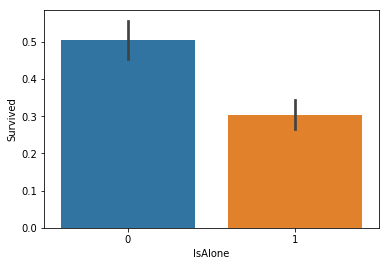

In [46]:
sns.barplot(data=train_df, x="IsAlone", y="Survived")

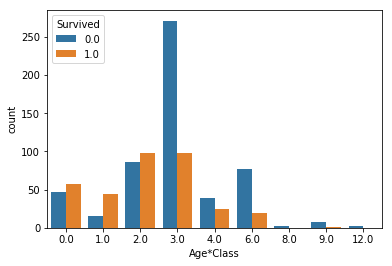

In [47]:
sns.countplot(data=train_df, x="Age*Class", hue="Survived")

----

## fill missing Embarked 

In [48]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

----

## Embarked categorical feature

### 1. Converting Embarked categorical feature to numeric

### 2. one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [49]:
train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

combine = [train_df, test_df]

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)

combine = [train_df, test_df]

----

## fill na of Fare in test data 

In [50]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
combine = [train_df, test_df]

----

## make Fareband feature

In [51]:
pd.qcut(train_df['Fare'], 4).value_counts(dropna=False)

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: Fare, dtype: int64

In [52]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    #print(dataset['Fare'].value_counts(dropna=False))
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

----

## drop Name, PassengerId

In [53]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

----

## final check data

In [54]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [55]:
train_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize', 'Fare',
       'IsAlone', 'Name_Len', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived',
       'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [56]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


In [57]:
test_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize', 'Fare',
       'IsAlone', 'Name_Len', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

----
# try to delete some features

### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

- Age*Class is duplicated. Age and Pclass is enough, i think

- Name_Len looks no meaning

- Ticket_Len looks no meaning

- Cabin_Num looks no meaning. Cabin null feature is included in Cabinb_Letter value.

In [58]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(891, 35) (418, 35)
Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize', 'Fare',
       'IsAlone', 'Name_Len', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived',
       'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object') Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize', 'Fare',
       'IsAlone', 'Name_Len', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Ticket_L

In [59]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [60]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


----

# model and estimate

In [61]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)
# 33, 

train/test data shape (596, 34) (295, 34)


----

## SVC

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:   10.2s finished


best parameters: {'svc__C': 30, 'svc__gamma': 0.005}
Mean cross-validated score of the best_estimator:  0.8204697986577181
test:  0.8271186440677966
confusion matrix:  [[152  23]
 [ 28  92]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.820470(std:0.036760)|[30, 0.005]
2|0.813758(std:0.035765)|[50, 0.005]
3|0.812081(std:0.044602)|[10, 0.005]
3|0.812081(std:0.052627)|[100, 0.001]
5|0.810403(std:0.052904)|[90, 0.001]
6|0.808725(std:0.034017)|[10, 0.01]
6|0.808725(std:0.055345)|[80, 0.001]
6|0.808725(std:0.037553)|[1000, 0.001]
9|0.807047(std:0.036806)|[10, 0.008]
10|0.803691(std:0.028919)|[30, 0.008]
10|0.803691(std:0.037404)|[70, 0.005]
10|0.803691(std:0.035461)|[500, 0.001]


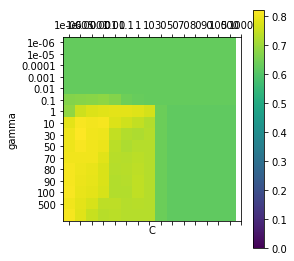

In [63]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, minmax scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 386 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    9.8s finished


best parameters: {'svc__C': 10, 'svc__gamma': 0.1}
Mean cross-validated score of the best_estimator:  0.8439597315436241
test:  0.8305084745762712
confusion matrix:  [[158  17]
 [ 33  87]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.843960(std:0.034023)|[10, 0.1]
2|0.842282(std:0.031780)|[90, 0.03]
3|0.840604(std:0.033690)|[50, 0.04]
3|0.840604(std:0.033690)|[80, 0.03]
3|0.840604(std:0.033772)|[100, 0.03]
6|0.838926(std:0.033871)|[30, 0.05]
7|0.837248(std:0.034022)|[70, 0.04]
7|0.837248(std:0.033792)|[90, 0.04]
9|0.835570(std:0.035204)|[70, 0.03]
10|0.833893(std:0.029367)|[30, 0.1]
10|0.833893(std:0.031769)|[50, 0.05]
10|0.833893(std:0.031769)|[80, 0.04]


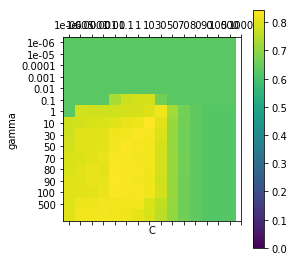

In [64]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(MinMaxScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, robust scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    9.9s finished


best parameters: {'svc__C': 10, 'svc__gamma': 0.008}
Mean cross-validated score of the best_estimator:  0.8171140939597316
test:  0.8406779661016949
confusion matrix:  [[156  19]
 [ 28  92]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.817114(std:0.047532)|[10, 0.008]
1|0.817114(std:0.045533)|[30, 0.005]
3|0.815436(std:0.049461)|[10, 0.005]
3|0.815436(std:0.029093)|[10, 0.03]
3|0.815436(std:0.032135)|[70, 0.01]
3|0.815436(std:0.031901)|[80, 0.008]
3|0.815436(std:0.030652)|[80, 0.01]
3|0.815436(std:0.032135)|[100, 0.008]
9|0.813758(std:0.042468)|[10, 0.01]
9|0.813758(std:0.032094)|[50, 0.01]
9|0.813758(std:0.030823)|[90, 0.008]


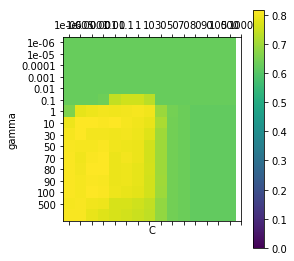

In [65]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(RobustScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, StandardScaler scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    9.7s finished


best parameters: {'svc__C': 10, 'svc__gamma': 0.008}
Mean cross-validated score of the best_estimator:  0.8355704697986577
test:  0.8203389830508474
confusion matrix:  [[150  25]
 [ 28  92]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.835570(std:0.044528)|[10, 0.008]
2|0.833893(std:0.044305)|[10, 0.005]
2|0.833893(std:0.024058)|[80, 0.008]
4|0.832215(std:0.036840)|[10, 0.01]
4|0.832215(std:0.037503)|[30, 0.005]
4|0.832215(std:0.022086)|[90, 0.008]
4|0.832215(std:0.022086)|[100, 0.008]
4|0.832215(std:0.042452)|[500, 0.001]
9|0.830537(std:0.038662)|[1, 0.03]
9|0.830537(std:0.023759)|[30, 0.01]
9|0.830537(std:0.027279)|[50, 0.01]


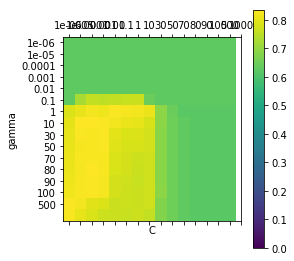

In [66]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

----

## KNeighborsClassifier

In [67]:
# no cale
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 3}
Mean cross-validated score of the best_estimator:  0.7298657718120806
test:  0.7593220338983051
confusion matrix:  [[149  26]
 [ 45  75]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.729866(std:0.045779)|[3]
1|0.729866(std:0.038852)|[4]
3|0.726510(std:0.045433)|[5]
4|0.724832(std:0.027008)|[15]
5|0.719799(std:0.048409)|[9]
6|0.718121(std:0.047107)|[7]
7|0.714765(std:0.039018)|[10]
7|0.714765(std:0.029299)|[20]
9|0.713087(std:0.043584)|[8]
10|0.703020(std:0.052022)|[6]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### minmax scaler

In [68]:
# minmax scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 5}
Mean cross-validated score of the best_estimator:  0.8338926174496645
test:  0.8169491525423729
confusion matrix:  [[153  22]
 [ 32  88]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.833893(std:0.022499)|[5]
1|0.833893(std:0.029436)|[7]
3|0.827181(std:0.030008)|[6]
4|0.825503(std:0.018679)|[8]
5|0.822148(std:0.013432)|[3]
6|0.817114(std:0.012461)|[4]
7|0.813758(std:0.043300)|[10]
8|0.808725(std:0.040209)|[9]
9|0.800336(std:0.027046)|[2]
10|0.791946(std:0.034248)|[20]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


### robust scaler

In [69]:
# robust scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(RobustScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 5}
Mean cross-validated score of the best_estimator:  0.7718120805369127
test:  0.8271186440677966
confusion matrix:  [[157  18]
 [ 33  87]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.771812(std:0.028851)|[5]
1|0.771812(std:0.029974)|[7]
3|0.766779(std:0.037557)|[3]
4|0.763423(std:0.018964)|[6]
4|0.763423(std:0.025636)|[20]
6|0.761745(std:0.018773)|[9]
7|0.758389(std:0.033331)|[4]
7|0.758389(std:0.022003)|[8]
9|0.755034(std:0.032733)|[15]
10|0.753356(std:0.031876)|[10]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


### StandardScaler

In [70]:
# StandardScaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 5}
Mean cross-validated score of the best_estimator:  0.8070469798657718
test:  0.7898305084745763
confusion matrix:  [[152  23]
 [ 39  81]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.807047(std:0.027288)|[5]
2|0.796980(std:0.012884)|[10]
3|0.793624(std:0.027078)|[9]
3|0.793624(std:0.029549)|[15]
5|0.783557(std:0.011682)|[2]
5|0.783557(std:0.016238)|[3]
7|0.781879(std:0.021263)|[4]
8|0.778523(std:0.027090)|[7]
8|0.778523(std:0.011696)|[8]
10|0.776846(std:0.029062)|[6]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


----

# random forest result for compare

**normal**

In [73]:
"""
# too wide
param_grid = {'randomforestclassifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25 None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2', None],
             'randomforestclassifier__min_samples_leaf': [1,2,3,4,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7],
             'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
              }
"""
# narrow down
param_grid = {'randomforestclassifier__max_depth':[5,6,7,8,9],
             'randomforestclassifier__max_features': [1,'sqrt','log2'],
#             'randomforestclassifier__min_samples_leaf': [1,2,3,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7,8,9],
             'randomforestclassifier__n_estimators': [10,20,30,40,50,60,100,200,300,500,700],
              }
pipe = make_pipeline(
#    SelectFromModel(RandomForestClassifier(n_estimators=100), threshold="median"), 
#    SelectFromModel(RandomForestClassifier(n_estimators=500), threshold="median"), 
#    SelectFromModel(
#        RandomForestClassifier(
#            max_depth=6, max_features="sqrt", 
#            min_samples_split=4,n_estimators=40)
#    ),
#    SelectPercentile(percentile=70),
    RandomForestClassifier()
)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=6, verbose=1)
#grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits


[Parallel(n_jobs=6)]: Done 229 tasks      | elapsed:    8.8s
[Parallel(n_jobs=6)]: Done 481 tasks      | elapsed:   20.0s
[Parallel(n_jobs=6)]: Done 911 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1476 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2376 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 3359 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done 4443 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 5601 tasks      | elapsed:  4.2min


best parameters: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__n_estimators': 50}
Mean cross-validated score of the best_estimator:  0.8422818791946308
test:  0.8372881355932204
confusion matrix:  [[158  17]
 [ 31  89]]

Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.842282(std:0.034964)|[7, 'log2', 9, 50]
2|0.840604(std:0.035120)|[6, 'sqrt', 9, 60]
2|0.840604(std:0.035273)|[6, 'log2', 6, 300]
4|0.838926(std:0.036377)|[6, 'sqrt', 6, 30]
4|0.838926(std:0.035046)|[6, 'sqrt', 6, 500]
4|0.838926(std:0.038007)|[6, 'log2', 4, 50]
4|0.838926(std:0.035841)|[6, 'log2', 4, 500]
4|0.838926(std:0.038142)|[7, 'sqrt', 5, 20]
4|0.838926(std:0.019342)|[8, 'sqrt', 7, 20]
4|0.838926(std:0.036475)|[8, 'sqrt', 9, 500]


[Parallel(n_jobs=6)]: Done 6600 out of 6600 | elapsed:  5.0min finished


In [74]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
22,Sex,0.178605
28,Title_Mr,0.159506
19,Name_Len,0.090982
21,Pclass,0.083675
29,Title_Mrs,0.042334
1,Age*Class,0.040755
27,Title_Miss,0.038295
15,Cabin_num_nan,0.037759
16,FamilySize,0.037182
24,Ticket_Len,0.035019


In [543]:
#pipe.fit(X_train_df, y_train_df)
grid_search.fit(X_train_df, y_train_df)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
report2(grid_search.cv_results_, n_top=10)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = grid_search.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_randomforest.csv', index=False)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits


[Parallel(n_jobs=6)]: Done 264 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done 482 tasks      | elapsed:   20.8s
[Parallel(n_jobs=6)]: Done 909 tasks      | elapsed:   40.7s
[Parallel(n_jobs=6)]: Done 1381 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2181 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3008 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 3912 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 5067 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 6433 tasks      | elapsed:  5.2min


best parameters: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 10}
Mean cross-validated score of the best_estimator:  0.8417508417508418
Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.841751(std:0.023075)|[8, 'log2', 3, 10]
2|0.840629(std:0.018609)|[8, 1, 6, 50]
3|0.839506(std:0.030570)|[8, 1, 5, 60]
3|0.839506(std:0.029845)|[9, 1, 9, 60]
5|0.838384(std:0.026129)|[7, 1, 5, 40]
5|0.838384(std:0.037062)|[7, 1, 9, 300]
5|0.838384(std:0.032934)|[8, 1, 9, 50]
8|0.837262(std:0.025256)|[9, 1, 6, 100]
9|0.836139(std:0.023981)|[7, 'sqrt', 3, 50]
9|0.836139(std:0.009261)|[8, 1, 9, 100]
9|0.836139(std:0.017224)|[8, 'sqrt', 8, 60]
9|0.836139(std:0.024330)|[9, 1, 9, 100]


[Parallel(n_jobs=6)]: Done 6600 out of 6600 | elapsed:  5.3min finished


**just trial of PolynomialFeatures(degree=2)**

In [518]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
14,Cabin_num_2.0,0.200314
10,Cabin_Letter_G,0.140428
7,Cabin_Letter_D,0.094102
9,Cabin_Letter_F,0.090553
13,Cabin_num_1.0,0.058617
15,Cabin_num_nan,0.057266
5,Cabin_Letter_B,0.056932
12,Cabin_num_0.0,0.056331
1,Age*Class,0.046098
6,Cabin_Letter_C,0.038108


----

## XGBoost

----

## AdaBoostClassifier

----

## GradientBoostingClassifier

**for submit, make model by best par and fit to all train data**

**just trial of PolynomialFeatures**

In [519]:
import warnings
warnings.simplefilter("ignore")